In [1]:
import numpy as np
import pandas as pd
import requests
import math
import json
import statistics
import pprint
import scipy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from Secrets.binance_secrets import BINANCE_API_KEY
from Secrets.binance_secrets import BINANCE_SECRET
from binance.client import Client

In [13]:
st = datetime.now()
et = st - timedelta(days=14)

st = int(st.timestamp()*1000)
et = int(et.timestamp()*1000)


print(st)
print(et)

1736666076461
1735456476461


In [3]:
client = Client(BINANCE_API_KEY, BINANCE_SECRET)

In [4]:
client.ping()

{}

In [5]:
open_in = 1
high_in = 2
low_in = 3
close_in = 4

symbols = ["BTCUSDT", "SOLUSDT", "AVAXUSDT", "ETCUSDT", "ETHUSDT", "RUNEUSDT", "CHRUSDT", "DOGEUSDT", "EOSUSDT", "LTCUSDT"]

In [7]:
# candle = client.get_klines(symbol='ETCUSDT', interval=Client.KLINE_INTERVAL_1HOUR, limit=1)
# print(candle[0][close_in])

for i in symbols:
    candle = client.get_klines(symbol=i, interval=Client.KLINE_INTERVAL_1DAY, startTime=et, endTime=st)
    print(candle)

[[1731542400000, '90375.21000000', '91790.00000000', '86668.21000000', '87325.59000000', '56729.51086000', 1731628799999, '5073860815.92866480', 9828858, '27940.85600000', '2499212755.77314710', '0'], [1731628800000, '87325.59000000', '91850.00000000', '87073.38000000', '91032.07000000', '47927.95068000', 1731715199999, '4276238971.18142940', 8009111, '24800.61087000', '2213154236.50961540', '0'], [1731715200000, '91032.08000000', '91779.66000000', '90056.17000000', '90586.92000000', '22717.87689000', 1731801599999, '2067958511.90484730', 4239455, '11496.31366000', '1046686701.00294610', '0'], [1731801600000, '90587.98000000', '91449.99000000', '88722.00000000', '89855.99000000', '23867.55609000', 1731887999999, '2153871724.81039480', 4930719, '11852.78227000', '1070094820.67389380', '0'], [1731888000000, '89855.98000000', '92594.00000000', '89376.90000000', '90464.08000000', '46545.03448000', 1731974399999, '4239909950.66189400', 7161125, '23628.87098000', '2153158394.31631090', '0'],

In [41]:
def portfolio(symbols, date):
    client = Client(BINANCE_API_KEY, BINANCE_SECRET)
    interval = Client.KLINE_INTERVAL_1DAY
    close_in = 4

    folio = {"Crypto":[], "Price":[], "week2":[], "week1":[], "day3":[], "perScore":[], "analysis":[]}

    end = int(date.timestamp()*1000)
    start = int((date - timedelta(days=15)).timestamp()*1000)

    for i in symbols:
        w2 = []
        w1 = []
        d3 = []

        response = client.get_historical_klines(symbol=i, interval=interval, start_str=start, end_str=end)
        size = len(response)

        current = float(response[size-1][close_in])

        for idx in range(size):
            w2.append(((current - float(response[idx][close_in]))/float(response[idx][close_in]))*100)

        for idx in range(6, size):
            w1.append(((current - float(response[idx][close_in]))/float(response[idx][close_in]))*100)
        
        for idx in range(10, size):
            d3.append(((current - float(response[idx][close_in]))/float(response[idx][close_in]))*100)

        # print(w2)

        folio["Crypto"].append(i)
        folio["Price"].append(current)
        folio["week2"].append(statistics.mean(w2))
        folio["week1"].append(statistics.mean(w1))
        folio["day3"].append(statistics.mean(d3))
    
    for i in range(len(folio["Crypto"])):
        score = folio["week2"][i]*0.3 + folio["week1"][i]*0.3 + folio["day3"][i]*0.4
        folio["perScore"].append(score)

        if score>=10:
            folio["analysis"].append("buy")
        elif score<10 and score>0:
            folio["analysis"].append("hold")
        else:
            folio["analysis"].append("sell")

    return folio

In [42]:
test = portfolio(symbols=symbols, date=(datetime.now()))

In [43]:
print(test)

{'Crypto': ['BTCUSDT', 'SOLUSDT', 'AVAXUSDT', 'ETCUSDT', 'ETHUSDT', 'RUNEUSDT', 'CHRUSDT', 'DOGEUSDT', 'EOSUSDT', 'LTCUSDT'], 'Price': [93877.42, 186.0, 36.54, 25.24, 3238.63, 3.377, 0.2108, 0.33556, 0.7898, 102.86], 'week2': [-1.900018280185712, -6.219652713183376, -4.935824140870455, -3.8762118702791217, -4.889813621512908, -20.47045608115539, -9.749911258532844, -2.1672747521209907, -4.028408578113558, -2.2961212063097975], 'week1': [-2.422747378577416, -6.334884534449413, -6.307351496628504, -4.14105049907637, -4.781572030771526, -15.574806344007541, -8.250682870253188, -4.763398093338597, -4.990153619898387, -3.1958400259233044], 'day3': [-0.29457634674256333, -1.4503673509700348, -0.6764140256869331, -0.296465448625324, -0.8554117327264504, -3.7703050997845, -1.6630375090635408, 0.283395575505795, -0.49955409686599433, -0.09953202845622329], 'perScore': [-1.4146602363259637, -4.34650811467785, -3.6435183015244608, -2.523764890256777, -3.24358038877591, -12.32170076746268, -6.0653

In [84]:
class backtest:
    init_investment = None
    init_portfolio = None
    total_value = 0
    old_value = 0
    new_value = 0
    s_date = None
    backtest_time = None
    balance = 0
    symbols = symbols
    portfolio_values = []
    total_evaluation = []
    old_portfolio = None

    def __init__(self):
        self.init_investment = float(input("Initial investment (USD): "))
        self.balance = self.init_investment

        self.backtest_time = int(input("Enter backtest time (years): "))
        self.s_date = datetime.now() - timedelta(days=365*self.backtest_time)

        self.init_portfolio = self.init_build()

        self.old_portfolio = self.init_portfolio

    def portfolio(self, symbols, date):
        client = Client(BINANCE_API_KEY, BINANCE_SECRET)
        interval = Client.KLINE_INTERVAL_1DAY
        close_in = 4

        folio = {"Crypto":[], "Price":[], "week2":[], "week1":[], "day3":[], "perScore":[], "analysis":[]}

        end = int(date.timestamp()*1000)
        start = int((date - timedelta(days=15)).timestamp()*1000)

        for i in symbols:
            w2 = []
            w1 = []
            d3 = []

            response = client.get_historical_klines(symbol=i, interval=interval, start_str=start, end_str=end)
            size = len(response)

            current = float(response[size-1][close_in])

            for idx in range(size):
                w2.append(((current - float(response[idx][close_in]))/float(response[idx][close_in]))*100)

            for idx in range(6, size):
                w1.append(((current - float(response[idx][close_in]))/float(response[idx][close_in]))*100)

            for idx in range(10, size):
                d3.append(((current - float(response[idx][close_in]))/float(response[idx][close_in]))*100)

            # print(w2)

            folio["Crypto"].append(i)
            folio["Price"].append(current)
            folio["week2"].append(statistics.mean(w2))
            folio["week1"].append(statistics.mean(w1))
            folio["day3"].append(statistics.mean(d3))

        for i in range(len(folio["Crypto"])):
            score = folio["week2"][i]*0.3 + folio["week1"][i]*0.3 + folio["day3"][i]*0.4
            folio["perScore"].append(score)

            if score>=10:
                folio["analysis"].append("buy")
            elif score<10 and score>0:
                folio["analysis"].append("hold")
            else:
                folio["analysis"].append("sell")

        print(folio)

        return folio

    def init_build(self):
        init_portfolio = portfolio(symbols=self.symbols, date=self.s_date)
        print(init_portfolio)

        folio = {"Crypto":[], "Holdings":[], "atPrice":[], "curPrice":[]}

        position_size = self.init_investment/len(init_portfolio["Crypto"])

        for i in range(len(init_portfolio['Crypto'])):
            folio['Crypto'].append(init_portfolio['Crypto'][i])
            folio['atPrice'].append(init_portfolio['Price'][i])
            folio['curPrice'].append(0)

            value = (position_size/init_portfolio['Price'][i])

            folio['Holdings'].append(value)

            self.old_value += value*folio['atPrice'][i]
            self.balance -= value*folio['atPrice'][i]

        return folio
    
    def update_portfolio(self):
        delta = 7
        # inter = 0
        iterations = int(self.backtest_time*365/delta)

        file_time = datetime.now().strftime("%Y_%m_%d_%H_%M")

        filename = f"BacktestLogs/test_backtest_log_{file_time}.txt"

        with open(filename, "a") as file:
                file.write(f"Backtesting Log {self.s_date.strftime('%Y-%m-%d')} to {(self.s_date + timedelta(days=self.backtest_time*365)).strftime('%Y-%m-%d')} \n\n")

        for _ in tqdm(range(iterations), desc="Backtesting Progress"):
            interim_value = 0

            with open(filename, "a") as file:
                file.write(f"\nDate: {(self.s_date + timedelta(days=delta)).strftime('%Y-%m-%d')}, Balance: {self.balance}, Value: {self.new_value}\n")

            time.sleep(15)

            interim = portfolio(self.symbols, self.s_date + timedelta(days=delta))

            for i in range(len(self.init_portfolio['Crypto'])):
                equal_size_balance = self.balance/len(self.init_portfolio['Crypto'])

                idx = interim['Crypto'].index(self.init_portfolio['Crypto'][i])

                if (interim['analysis'][idx]=='buy' and self.init_portfolio['Holdings'][i]==0 and self.balance>0):
                    self.balance -= self.init_portfolio['Holdings'][i]*interim['Price'][idx]
                    self.init_portfolio['Holdings'][i] += (equal_size_balance/interim['Price'][idx])

                    with open(filename, "a") as file:
                        file.write(f"Bought {(equal_size_balance/interim['Price'][idx])} quantity of {interim['Crypto'][idx]}\n")

                elif (interim['analysis'][idx]=='sell' and self.init_portfolio['Holdings'][i]!=0):
                    self.balance += self.init_portfolio['Holdings'][i]*interim['Price'][idx]

                    with open(filename, "a") as file:
                        file.write(f"Sold {self.init_portfolio['Holdings'][i]} quantity of {interim['Crypto'][idx]}\n")

                    self.init_portfolio['Holdings'][i] = 0

                elif (interim['analysis'][idx]=='buy' and self.init_portfolio['Holdings'][i]!=0 and equal_size_balance>0):
                    self.init_portfolio['Holdings'][i] += (equal_size_balance/interim['Price'][idx])
                    self.balance -= (equal_size_balance/interim['Price'][idx])*interim['Price'][idx]

                    with open(filename, "a") as file:
                        file.write(f"Bought {(equal_size_balance/interim['Price'][idx])} quantity of {interim['Crypto'][idx]}\n")

                self.init_portfolio['curPrice'][i] = interim['Price'][idx]
            
            for i in range(len(interim)):
                equal_size_balance = self.balance/10

                if ((interim['Crypto'][i] not in self.init_portfolio['Crypto']) and equal_size_balance>interim['Price'][i] and interim['analysis']=='buy'):
                    self.init_portfolio['Crypto'].append(interim['Crypto'][i])

                    holdings = (equal_size_balance/interim['Price'][i])
                    self.init_portfolio['Holdings'].append(holdings)
                    self.balance -= equal_size_balance

                    self.init_portfolio['atPrice'].append(interim['Price'][i])
                
                self.init_portfolio['curPrice'].append(interim['Price'][i])

            
            for i in range(len(self.init_portfolio['Crypto'])):
                interim_value += self.init_portfolio['Holdings'][i]*self.init_portfolio['curPrice'][i]
            
            self.portfolio_values.append(interim_value)
            self.total_evaluation.append(interim_value + self.balance)

            delta += 7

        for i in range(len(self.init_portfolio['Crypto'])):
            self.new_value += self.init_portfolio['Holdings'][i]*self.init_portfolio['curPrice'][i]
    
    def create_initial_chart(self):
        portfolio = self.init_portfolio
        initial_value = 0

        for i in range(len(portfolio['Crypto'])):
            initial_value += portfolio['Holdings'][i]*portfolio['atPrice'][i]

        cmap = plt.get_cmap('viridis')  # Example colormap

        # Create pie chart
        fig, ax = plt.subplots()

        # Pie chart segments
        wedges, texts = ax.pie(portfolio['Holdings'], autopct=None, startangle=140, colors=cmap(np.linspace(0, 1, len(portfolio['Crypto']))))

        # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.axis('equal')

        legend_labels = [f'{label}: {size}' for label, size in zip(portfolio['Crypto'], portfolio['Holdings'])]

        ax.legend(wedges, legend_labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        # Title
        plt.title(f'Portfolio Details, Initial Investment: {initial_value:.2f}')

        plt.show()

    def new_graph(self):
        portfolio = self.init_portfolio
        initial_value = 0

        for i in range(len(portfolio['Crypto'])):
            initial_value += portfolio['Holdings'][i]*portfolio['curPrice'][i]

        cmap = plt.get_cmap('viridis')  # Example colormap

        # Create pie chart
        fig, ax = plt.subplots()

        # Pie chart segments
        wedges, texts = ax.pie(portfolio['Holdings'], autopct=None, startangle=140, colors=cmap(np.linspace(0, 1, len(portfolio['Crypto']))))

        # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.axis('equal')

        legend_labels = [f'{label}: {size}' for label, size in zip(portfolio['Crypto'], portfolio['Holdings'])]

        ax.legend(wedges, legend_labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        # Title
        plt.title(f'Portfolio Details, Current Valuation: {initial_value:.2f}')

        plt.show()

    def portfolio_growth(self):
        y_values = self.portfolio_values
        x_values = np.arange(0, len(self.portfolio_values))

        plt.figure(figsize=(12, 8))  # Width=12 inches, Height=8 inches

        # Create the plot
        plt.plot(x_values, y_values, label='Portfolio Growth Chart', color='red')

        # Add labels and title
        plt.xlabel('Time Frame (months from the start)')
        plt.ylabel('Portfolio Value ($)')
        plt.title('Portfolio Growth Chart')
        plt.legend()

        # Display the plot
        plt.show()

    def evaluation(self):
        y_values = self.total_evaluation
        x_values = np.arange(0, len(self.total_evaluation))

        plt.figure(figsize=(12, 8))  # Width=12 inches, Height=8 inches

        # Create the plot
        plt.plot(x_values, y_values, label='Total Evaluation Growth', color='green')

        # Add labels and title
        plt.xlabel('Time Frame (months from the start)')
        plt.ylabel('Evaluation ($)')
        plt.title('Evaluation Growth Chart')
        plt.legend()

        # Display the plot
        plt.show()

    def calculate_CAGR(self):
        
        Vf = self.new_value + self.balance
        Vi = self.old_value
        n = math.ceil(self.backtest_time)

        print(f"Final Value: {Vf:.2f}")
        print(f"Initial Value: {Vi:.2f}")
        print("Time (years): ", n)

        cagr = (((Vf/Vi)**(1/n)) - 1)*100

        print(f"CAGR: {cagr:.2f}")

In [85]:
test = backtest()

{'Crypto': ['BTCUSDT', 'SOLUSDT', 'AVAXUSDT', 'ETCUSDT', 'ETHUSDT', 'RUNEUSDT', 'CHRUSDT', 'DOGEUSDT', 'EOSUSDT', 'LTCUSDT'], 'Price': [42847.99, 95.85, 36.49, 28.59, 2578.19, 4.581, 0.2565, 0.08092, 0.764, 71.98], 'week2': [-3.127633697668108, -3.492578285349925, -2.1823979197123013, 27.42882610925714, 9.384726571030667, -9.033706834045494, 9.111417401090957, -3.3584547989057745, -1.575310864497308, 3.7825126242854443], 'week1': [-4.366661661588363, -0.705380275820501, 1.0633799165957663, 23.662726032466058, 7.3122158189338755, -5.328419886338214, 2.9795580017331043, -0.27057431807184923, 2.610029964977566, 5.1004095992323455], 'day3': [-4.5227506022433985, -1.913401615865494, -1.1104478993589617, 7.612135556083049, 2.0846051585969403, -4.4990227025438845, -3.263795793240101, -0.7396425726139214, 1.1506847110104328, 1.7826309613317755], 'perScore': [-4.057388848674301, -2.0247482146973255, -0.7798845606785452, 18.372319864950178, 5.842924780428138, -6.108247097132667, 2.32177430355117

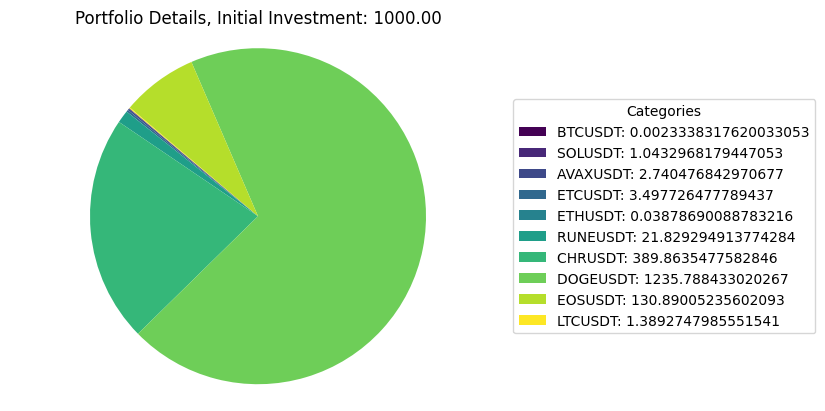

In [86]:
test.create_initial_chart()

In [87]:
test.update_portfolio()

Backtesting Progress: 100%|██████████| 52/52 [16:57<00:00, 19.56s/it]


In [89]:
test.balance

15402.955657678325

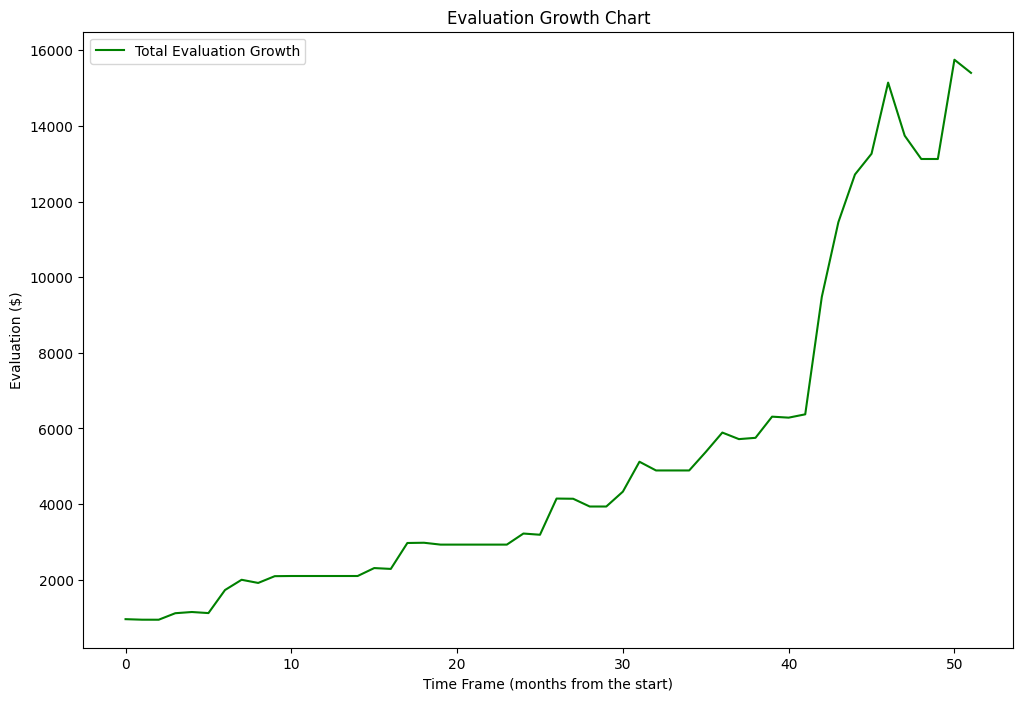

In [91]:
test.evaluation()

In [92]:
test.calculate_CAGR()

Final Value: 15402.96
Initial Value: 1000.00
Time (years):  1
CAGR: 1440.30
